## Convolution Neural Network built fully mainly with linear alegbra and chain rule of calculus

* Note that tensorflow and scipy are only used to load the dataset in, and for the correlate math function simply for convience of this project, It does not functional take away from the object of this project. 

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
import scipy.signal as signal 
import matplotlib.pyplot as plt

In [35]:
# load the data in
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

# normalize
x_train = x_train.astype(np.float32) / 255.0
x_test = x_test.astype(np.float32) / 255.0

# reshape to (n, 1, 28, 28) for cnn input
x_train_cnn = x_train.reshape(-1, 1, 28, 28)
x_test_cnn = x_test.reshape(-1, 1, 28, 28)

# one-hot encode the targets
y_train_oh = np.eye(10)[y_train].reshape(-1, 10, 1)
y_test_oh = np.eye(10)[y_test].reshape(-1, 10, 1)

number_training = x_train_cnn.shape[0]

shuffled_indices = np.random.permutation(number_training)

# shuffle
x_train_cnn = x_train_cnn[shuffled_indices]
y_train_oh= y_train_oh[shuffled_indices]

# checks
assert x_train_cnn.shape[0] == y_train_oh.shape[0], "Number of training samples must match number of labels. Error in loading data."

## A visualization of the images that we are working with are shown below

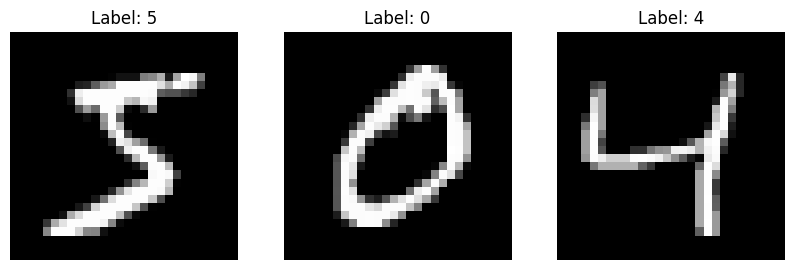

In [45]:
plt.figure(figsize=(10, 3))
for i in range(3):
    plt.subplot(1, 3, i + 1)
    plt.imshow(x_train[i], cmap='gray')
    plt.title(f"Label: {y_train[i]}")
    plt.axis('off')
plt.show()

In [ ]:
class layer:
    def __init__(self):
        self.input = None
        self.output = None

    def forward(self, input):
        # TODO: return output
        pass

    def backward(self, output_gradient, learning_rate):
        # TODO: update weights and return input gradient
        pass

class convolution(layer):
    """
    The depth is number of kernals 
    """ 
    def __init__(self, kernel_size : int, input_shape : tuple , depth : int): 
        input_depth, input_height, input_width = input_shape
        self.depth = depth
        self.input_shape = input_shape
        self.input_depth = input_depth
        self.output_shape = (depth, input_height - kernel_size + 1, input_width - kernel_size + 1)
        self.kernels_shape = (depth, input_depth, kernel_size, kernel_size)
        self.kernels = np.random.randn(*self.kernels_shape)  * 0.01
        self.biases = np.random.randn(*self.output_shape) * 0.01
        
    def forward(self, input):
        self.input = input
        self.output = np.copy(self.biases)
        for i in range(self.depth):
            for j in range(self.input_depth):
                self.output[i] += signal.correlate2d(self.input[j], self.kernels[i, j], "valid")
        return self.output
    
    def backward(self, output_gradient, learning_rate):
        """ 
        Kernal gradient is ∂E/∂K = Xj * ∂E/∂Y
        Biases gradient is ∂E/∂B = ∂E/∂Y - This is given by the output gradient, this will be the gradient of the loss funtion
        Input gradient is ∂E/∂X = ∑(∂E/∂Y *(full) K)
        """
        kernels_gradient = np.zeros(self.kernels_shape)
        input_gradient = np.zeros(self.input_shape)

        for i in range(self.depth):
            for j in range(self.input_depth):
                kernels_gradient[i, j] = signal.correlate2d(self.input[j], output_gradient[i], "valid")
                input_gradient[j] += signal.convolve2d(output_gradient[i], self.kernels[i, j], "full")

        self.kernels -= learning_rate * kernels_gradient
        self.biases -= learning_rate * output_gradient
        return input_gradient
    
class reshape(layer): 
    def __init__(self, input_shape, output_shape):
        self.input_shape = input_shape
        self.output_shape = output_shape

    def forward(self, input):
        return np.reshape(input ,self.output_shape)

    def backward(self, output_gradient, learning_rate):
        return np.reshape(output_gradient, self.input_shape)


class dense(layer): 
    def __init__(self, input_size, output_size):
        self.weights = np.random.randn(input_size, output_size)
        self.biases = np.zeros((output_size, 1))  
        
    def forward(self, input):
        self.input = input
        self.output = np.dot(self.weights.T, input) + self.biases
        return self.output
    
    def backward(self, output_gradient, learning_rate):
        input_gradient = np.dot(self.weights, output_gradient)
        weights_gradient = np.dot(self.input, output_gradient.T)
        self.weights -= learning_rate * weights_gradient
        self.biases -= learning_rate * output_gradient
        return input_gradient  
       
       
class activation(layer):
    def __init__(self, activation, activation_prime):
        self.activation = activation
        self.activation_prime = activation_prime

    def forward(self, input):
        self.input = input
        return self.activation(self.input)

    def backward(self, output_gradient, learning_rate):
        return np.multiply(output_gradient, self.activation_prime(self.input))

class relu(activation):
    def __init__(self):
        def relu(x):
            return np.maximum(0, x)
        def relu_prime(x):
            return (x > 0).astype(float)
        super().__init__(relu, relu_prime)
        
def softmax(x):
    e_x = np.exp(x - np.max(x))
    return e_x / np.sum(e_x, axis=0, keepdims=True)

def categorical_cross_entropy(y_true, y_pred):
    return -np.sum(y_true * np.log(y_pred + 1e-8))

def categorical_cross_entropy_prime(y_true, y_pred):
    return y_pred - y_true




In [ ]:
network = [
    convolution(kernel_size=3, input_shape=(1, 28, 28), depth=5),
    relu(),
    reshape(input_shape=(5, 26, 26), output_shape=(5 * 26 * 26, 1)),
    dense(5 * 26 * 26, 100),
    relu(),
    dense(100, 10)          
]

In [ ]:
def predict(network, input):
    output = input
    for layer in network:
        output = layer.forward(output)
    output = softmax(output) 
    return output

def train(network, loss, loss_prime, x_train, y_train, epochs = 1000, learning_rate = 0.01, verbose = True):
    for e in range(epochs):
        error = 0
        for x, y in zip(x_train, y_train):
            # forward
            output = predict(network, x)

            # error
            error += loss(y, output)

            # backward
            grad = loss_prime(y, output)
            for layer in reversed(network):
                grad = layer.backward(grad, learning_rate)

        error /= len(x_train)
        if verbose:
            print(f"{e + 1}/{epochs}, error={error}")

In [ ]:
n_samples = 5000

x_train_cnn_small = x_train_cnn[:n_samples]
y_train_oh_small = y_train_oh[:n_samples]
x_test_cnn_small = x_test_cnn[:n_samples]
y_test_oh_small = y_test_oh[:n_samples]

# train
train(
    network,
    categorical_cross_entropy,
    categorical_cross_entropy_prime,
    x_train_cnn_small,
    y_train_oh_small,
    epochs=20, # fewer epochs for speed, and cause I am on a cpu 
    learning_rate=0.01
)

# test
correct = 0
total = len(x_test_cnn_small)
for x, y in zip(x_test_cnn_small, y_test_oh_small):
    output = predict(network, x)
    pred = np.argmax(output)
    true = np.argmax(y)
    if pred == true:
        correct += 1
    print(f"pred: {pred}, true: {true}")
print(f"Accuracy: {correct/total:.2%}")

1/20, error=0.6585352059274021
2/20, error=0.4257140693930467
3/20, error=0.34903301016377347
